# HRRR-Alaska

This will plot HRRR-Alaska data. There are additional "products" available than are shown here.

In [1]:
from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint

import matplotlib.pyplot as plt

In [2]:
H = Herbie(
    "2021-07-19",
    model="hrrrak",
    product="sfc",
    fxx=6,
)

✅ Found ┊ model=hrrrak ┊ product=sfc ┊ 2021-Jul-19 00:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws


In [3]:
# Show additional products
H.PRODUCTS

{'prs': '3D pressure level fields; 3-km resolution',
 'sfc': '2D surface level fields; 3-km resolution',
 'nat': 'Native level fields; 3-km resolution',
 'subh': 'Subhourly grids; 3-km resolution'}

In [4]:
ds = H.xarray("TMP:2 m above")
ds

<xarray.Dataset> Size: 24MB
Dimensions:              (y: 919, x: 1299)
Coordinates:
    time                 datetime64[ns] 8B 2021-07-19
    step                 timedelta64[ns] 8B 06:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 10MB 41.61 41.63 41.64 ... 76.35 76.34
    longitude            (y, x) float64 10MB 185.1 185.1 185.2 ... 244.1 244.2
    valid_time           datetime64[ns] 8B 2021-07-19T06:00:00
    gribfile_projection  object 8B None
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 5MB 289.4 289.4 289.4 ... 271.9 272.2
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrrak
    product:                 sfc
    description:             High-Resolution Rapid Refresh - Alaska
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrrak/20210719/subset_6eb29...
    search:                  TMP:2 m above

Text(0.0, 1.0, 'HRRRAK: 2D surface level fields; 3-km resolution')

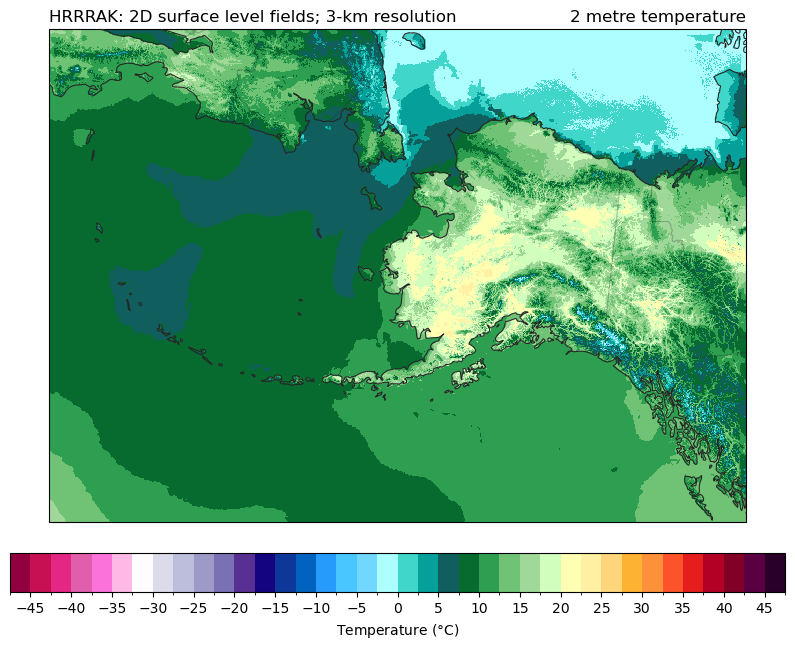

In [5]:
ax = EasyMap("50m", crs=ds.herbie.crs, figsize=[10, 8]).STATES().ax

p = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t2m - 273.15,
    transform=pc,
    **paint.NWSTemperature.kwargs2,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.05,
    **paint.NWSTemperature.cbar_kwargs2,
)

ax.set_title(ds.t2m.GRIB_name, loc="right")
ax.set_title(f"{ds.model.upper()}: {H.product_description}", loc="left")

In [6]:
ds.t2m.attrs

{'GRIB_paramId': 167,
 'GRIB_dataType': 'fc',
 'GRIB_numberOfPoints': 1193781,
 'GRIB_typeOfLevel': 'heightAboveGround',
 'GRIB_stepUnits': 1,
 'GRIB_stepType': 'instant',
 'GRIB_gridType': 'polar_stereographic',
 'GRIB_NV': 0,
 'GRIB_cfName': 'air_temperature',
 'GRIB_cfVarName': 't2m',
 'GRIB_gridDefinitionDescription': 'Polar stereographic can be south or north',
 'GRIB_missingValue': 3.4028234663852886e+38,
 'GRIB_name': '2 metre temperature',
 'GRIB_parameterName': 'Temperature',
 'GRIB_parameterUnits': 'K',
 'GRIB_shortName': '2t',
 'GRIB_stepRange': '6',
 'GRIB_units': 'K',
 'long_name': '2 metre temperature',
 'units': 'K',
 'standard_name': 'air_temperature',
 'grid_mapping': 'gribfile_projection'}

Below is tying to use metpy to parse the CF grid_namming

In [7]:
# my own implementation to get cartopy projection
ds.herbie.crs.proj4_params

{'ellps': 'sphere',
 'a': 6371229.0,
 'b': 6371229.0,
 'proj': 'stere',
 'lat_0': 90,
 'lon_0': 225.0,
 'x_0': 0.0,
 'y_0': 0.0,
 'lat_ts': 60.0}

In [8]:
ds.metpy.parse_cf().metpy_crs.item().to_cartopy().proj4_params

{'ellps': 'sphere',
 'a': 6371229.0,
 'b': 6371229.0,
 'proj': 'stere',
 'lat_0': 90,
 'lon_0': 225.0,
 'x_0': 0.0,
 'y_0': 0.0,
 'lat_ts': 60.0}

In [9]:
# What if I don't specify anything?
ds.gribfile_projection.attrs["straight_vertical_longitude_from_pole"] = None
ds.gribfile_projection.attrs["standard_parallel"] = None
ds.gribfile_projection.attrs["latitude_of_projection_origin"] = 90

In [10]:
ds.metpy.parse_cf().metpy_crs.item().to_cartopy()

<Projected CRS: +proj=stere +ellps=sphere +a=6371229.0 +b=6371229. ...>
Name: unknown
Axis Info [cartesian]:
- E[south]: Easting (metre)
- N[south]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Polar Stereographic (variant A)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [11]:
ds.metpy.parse_cf().metpy_crs.item().to_cartopy().proj4_params

{'ellps': 'sphere',
 'a': 6371229.0,
 'b': 6371229.0,
 'proj': 'stere',
 'lat_0': 90,
 'lon_0': None,
 'x_0': 0.0,
 'y_0': 0.0}

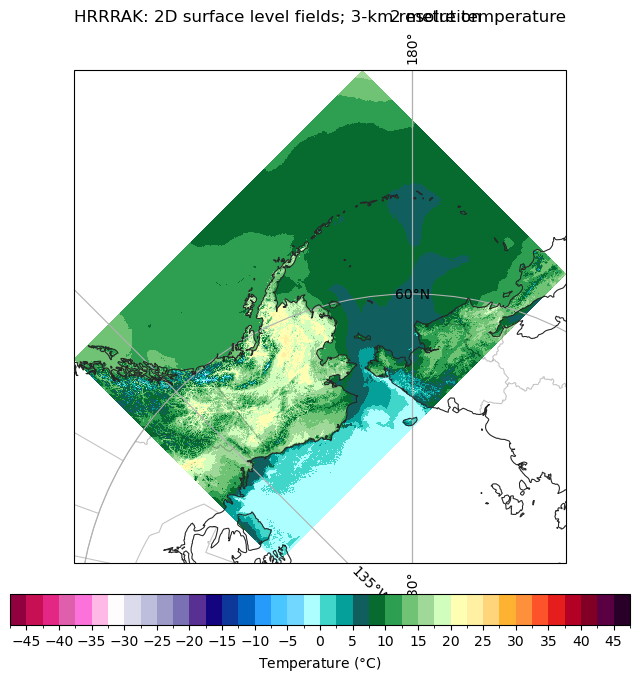

In [12]:
ax = (
    EasyMap(
        "50m", crs=ds.metpy.parse_cf().metpy_crs.item().to_cartopy(), figsize=[8, 8]
    )
    .STATES()
    .ax
)
p = ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.t2m - 273.15,
    transform=pc,
    **paint.NWSTemperature.kwargs2,
)
plt.colorbar(
    p,
    ax=ax,
    orientation="horizontal",
    pad=0.05,
    **paint.NWSTemperature.cbar_kwargs2,
)

ax.set_title(ds.t2m.GRIB_name, loc="right")
ax.set_title(f"{ds.model.upper()}: {H.product_description}", loc="left")
gl = ax.gridlines(draw_labels=True)

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker

gl.ylocator = mticker.FixedLocator([60])
gl.xlocator = mticker.FixedLocator([-180, -135, 180])